In [1]:
"""
    Copyright (c) 2021 Olivier Leblanc

    Permission is hereby granted, free of charge, to any person obtaining
    a copy of this software and associated documentation files (the "Software"),
    to deal in the Software without restriction, including without limitation
    the rights to use, copy, modify, merge, publish, distribute, and to permit
    persons to whom the Software is furnished to do so.
    However, anyone intending to sublicense and/or sell copies of the Software
    will require the official permission of the author.
    ----------------------------------------------------------------------------

    Author : Olivier Leblanc
    Date : 04/05/2022

    Code description :
    __________________
    Generates sparse object in various bases and recover it 
    by solving an inverse problem from rank-one projections.
    This file aims to numerically compare the link between the sparsity prior and reconstruction quality regarding the parameters setting.
    The numerical solver is Basis Pursuit (BP) or denoiser extensions from SPGL1 toolbox.
"""
import matplotlib.pyplot as plt
import numpy as np
from pyunlocbox import functions, solvers, acceleration
import pywt
import spgl1

import sys, os
def updir(d, n):
  for _ in range(n):
    d = os.path.dirname(d)
  return d
sys.path.append(os.path.join(updir(os.getcwd(),3),'utils'))

from interferometric_lensless_imaging import * # ROP projectors, rmdiag,...
# set_plot_params() # Set the plot params
from IHT import IHT
from utils_wavelet import *
from functions import *

In [2]:
def plotrec(x, x_hat):
    plt.figure()
    plt.plot(x, 'o', label='Original')
    plt.plot(x_hat, 'xr', label='Reconstructed')
    plt.grid(True)
    plt.title('Achieved reconstruction')
    plt.legend(numpoints=1)
    plt.xlabel('Signal dimension number')
    plt.ylabel('Signal value')
    plt.show()

In [3]:
N = 256 # vector size
K = 6 # sparsity
Q = 80 # Number of cores
M = 70 # Number of observations y

" From analytical developments, beware of the np.conj!!"
a_ij = (np.random.randn(M,Q)+1j*np.random.randn(M,Q))/np.sqrt(2)
pos_cores = np.random.permutation(np.arange(N))[:Q] # random cores locations
# pos_cores = np.round(np.arange(Q)*(N-1)/(Q-1)).astype(int) # regularly spaced cores locations
beta = np.zeros((M,N), dtype=complex)
beta[:, pos_cores] = a_ij
beta2 = corr_circ(beta.conj()) # autocorrelations of beta

In [4]:
bpalg = lambda A, b: spgl1.spg_bp(A, b, opt_tol=1e-7, bp_tol=1e-7)[0]
bpdnalg = lambda A, b, sigma: spgl1.spg_bpdn(A, b, sigma)[0]
lasso = lambda A, b, tau: spgl1.spg_lasso(A, b, tau)[0]

# Sparse in the spatial domain

$
    \begin{array}{ll}
    \boldsymbol{y} &= \left\{ (\boldsymbol{\beta}_m * \overline{\boldsymbol{\beta}}_m)^\top \boldsymbol{F f} \right\}_{m=1}^M + \boldsymbol{n} \\
    &= \boldsymbol{\Beta Ff} + \boldsymbol{n}
    \end{array} 
$

where $*$ is the convolution operator, $\Beta$ is a $M \times N$ matrix whose lines are $\left\{ (\boldsymbol{\beta}_m * \overline{\boldsymbol{\beta}}_m) \right\}_{m=1}^M$ and $\boldsymbol{F}$ is the linear operator applying 1D Fourier transform. 

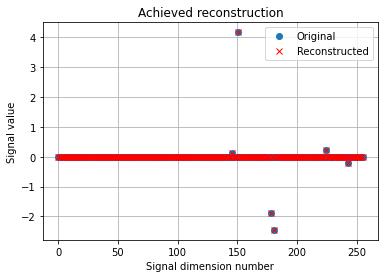

SNR: 67.10 dB
SNR: 68.49 dB
SNR: 51.12 dB


In [5]:
"Define the sparse object"
f = np.zeros(N)
indices = np.random.permutation(np.arange(N))[:K] 
f[indices[:-1]] = np.random.randn(K-1)
f[indices[-1]] = -np.sum(f)

A_corr = Autocorr_model(beta2, wt=None)
y_corr = A_corr@f
x_corr = bpalg(A_corr, y_corr)
x_corr2 = bpdnalg(A_corr, y_corr,1e-10)
x_corr_lasso = lasso(A_corr, y_corr, tau=np.linalg.norm(f,1))

plotrec(f, x_corr)

print('SNR: {:.2f} dB'.format(snr(f, x_corr)) )
print('SNR: {:.2f} dB'.format(snr(f, x_corr2)) )
print('SNR: {:.2f} dB'.format(snr(f, x_corr_lasso)) )

# Sparse in Haar wavelets

$
    \begin{array}{ll}
    \boldsymbol{y} &= \left\{ (\boldsymbol{\beta}_m * \overline{\boldsymbol{\beta}}_m)^\top \boldsymbol{F f} \right\}_{m=1}^M + \boldsymbol{n} \\
    &= \boldsymbol{\Beta F \Psi \alpha} + \boldsymbol{n}
    \end{array} 
$

where $*$ is the convolution operator, $\Beta$ is a $M \times N$ matrix whose lines are $\left\{ (\boldsymbol{\beta}_m * \overline{\boldsymbol{\beta}}_m) \right\}_{m=1}^M$, $\boldsymbol{F}$ is the linear operator applying 1D Fourier transform and $\boldsymbol{\Psi}$ is the Haar Wavelet transform written in matrix format with the associated wavelet coefficients $\boldsymbol{\alpha}$. 

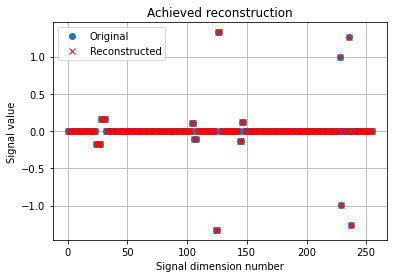

SNR: 158.61 dB
SNR: 102.83 dB
SNR: 73.73 dB


In [6]:
"Define the sparse object"
alpha = np.zeros(N)
indices = np.random.permutation(np.arange(N))[:K] 
alpha[indices[:-1]] = np.random.randn(K-1)
alpha[indices[-1]] = -np.sum(alpha)

A_corr = Autocorr_model(beta2, wt='haar')

y_corr = A_corr@alpha
x_corr = bpalg(A_corr, y_corr)
x_corr2 = bpdnalg(A_corr, y_corr,1e-10)
x_corr_lasso = lasso(A_corr, y_corr, tau=np.linalg.norm(alpha,1))

f_corr = A_corr.wavT(x_corr)
f_wav = A_corr.wavT(alpha)

plotrec(f_wav, f_corr)

print('SNR: {:.2f} dB'.format(snr(f_wav, f_corr)) )
print('SNR: {:.2f} dB'.format(snr(f_wav, A_corr.wavT(x_corr2))) )
print('SNR: {:.2f} dB'.format(snr(f_wav, A_corr.wavT(x_corr_lasso))) )

# Sparse in TV - Piecewise constant

Solve 
$
    \hat f = \argmin_f~\frac{1}{2} \left\lVert \boldsymbol y - \boldsymbol{\Beta F f} \right\rVert_2^2 + \lambda \left\lVert f \right\rVert_{\text{TV}}
$

Solution found after 5000 iterations:
    objective function f(sol) = 3.381969e+01
    stopping criterion: MAXIT


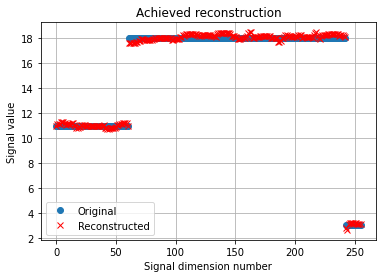

SNR: 37.59 dB


In [10]:
"Define the sparse object"
f = np.zeros(N)
n_piece = 4
maxrand = 30
randvals = np.random.randint(maxrand, size=n_piece)
cuts = np.sort((np.random.rand(n_piece-1)*N).astype(int))
f[:cuts[0]] = randvals[0]
f[cuts[-1]:] = randvals[-1]
for i in range(n_piece-2):
    f[cuts[i]:cuts[i+1]] = randvals[i+1]

"ROP model"
A_op = lambda xin: A_corr@xin
At_op = lambda xin: A_corr.T@xin
nu_rop1 = eval_nu(np.random.randn(N), A_op, At_op, nb_iter=50)*1.01

y = A_op(f)

f1 = functions.norm_tv(maxit=80, dim=1)
f2 = functions.norm_l2(y=y, A=A_op, At=At_op, nu=nu_rop1)
solver = solvers.forward_backward(step=0.5/nu_rop1)
x0 = At_op(y)
ret1 = solvers.solve([f1, f2], x0, solver, rtol=1e-7, maxit=5000)

plotrec(f, ret1['sol'])

print('SNR: {:.2f} dB'.format(snr(f, ret1['sol'])) )